In [2]:
import numpy as np # installing packages
import matplotlib.pyplot as plt

In [3]:
# Constants & Parameters
rho = 1060.0                # blood density kg/m^3
Aref_cm2 = 7.0              # reference area for semilunar valves (cm^2)
Aref = Aref_cm2 * 1e-4      # cm^2 → m^2

# Healthy and severe stenosis parameters
Mmax_healthy = 0.95
Mmax_stenosis = 0.1         # severe as per Gerach et al. (2023)
Mmin = 0.001

# Valve rate constants
Ko_mmHg = 10.0
Kc_mmHg = 6.0

# Unit conversions
mmHg_to_Pa = 133.322368421052
Pa_to_mmHg = 1.0 / mmHg_to_Pa

# Simple arterial model
R = 1.6e8           # Pa·s/m^3
C = 1.5e-8          # m^3/Pa

In [4]:
# LV elastance shape (Gerach et al. table 1)
T = 0.8       # heart period 
t0 = 0.15
mc = 1.32
mr = 14.5
tau_c = 0.215
tau_r = 0.362

LV_press_baseline_mmHg = 8.0
LV_press_amp_mmHg = 100.0

def e_timecourse(t): # Elastance of the left ventricle (Gerarch et al. eq. 2)
    tprime = ((t - t0) % T)
    gc = (tprime / tau_c) ** mc if tau_c > 0 else 0
    gr = (tprime / tau_r) ** mr if tau_r > 0 else 0
    return (gc / (1 + gc)) * (1 / (1 + gr))

# normalize e(t)
ts_norm = np.linspace(0, T, 1000)
e_raw = np.array([e_timecourse(t) for t in ts_norm])
k_norm = e_raw.max()

def e_norm(t):
    return e_timecourse(t) / (k_norm + 1e-16)

def p_LV_mmHg(t):
    return LV_press_baseline_mmHg + LV_press_amp_mmHg * e_norm(t)


In [5]:
# -----------------------
# Valve model (A_eff, Bernoulli, inertia, sigma dynamics)
# -----------------------
def compute_A_eff(s): # Computing A_eff using the formula from Gerarch et al. (2023)
    s = np.clip(s, 1e-9, 1 - 1e-9)
    return Aref * s / (1 - s)

def valve_rhs(state, t, params): # 
    Q, sigma, p_a = state
    Mmax = params["Mmax"]

    # valve opening fraction 
    s = (Mmax - Mmin) * sigma + Mmin # (Gerarch et al. eq. 9)
    Aeff = compute_A_eff(s) # (Gerarch et al. eq. 9)

    # valve model derived from Bernoulli equation (Gerarch et al. eq. 5)
    B = rho / (2 * Aeff**2)
    Ls = 6.28 * rho / np.sqrt(Aeff)

    p_lv_pa = p_LV_mmHg(t) * mmHg_to_Pa
    delta_p_pa = p_lv_pa - p_a
    delta_p_mmHg = delta_p_pa * Pa_to_mmHg

    # blood flow ODE (Gerarch et al. eq. 5)
    dQ_dt = (delta_p_pa - B * np.abs(Q) * Q) / Ls

    # valve dynamics (open and closed valve ODE) (Gerarch et al. eq. 10)
    if delta_p_mmHg > 0:
        d_sigma_dt = Ko_mmHg * (1 - sigma) * delta_p_mmHg
    else:
        d_sigma_dt = Kc_mmHg * sigma * delta_p_mmHg

    # arterial pressure ODE
    dp_a_dt = (Q - p_a / R) / C

    return np.array([dQ_dt, d_sigma_dt, dp_a_dt])


In [6]:
# define numerical methods
def num_methods(rhs, y0, tspan, dt, params, method="rk4"):
    n = int((tspan[1] - tspan[0]) / dt)
    ts = np.linspace(tspan[0], tspan[1], n+1)
    ys = np.zeros((n+1, len(y0)))
    ys[0] = y0

    for i in range(n):
        t = ts[i]
        y = ys[i]

        if method == "rk4": # Runge-Kutta 4 method
            k1 = rhs(y, t, params)
            k2 = rhs(y + 0.5*dt*k1, t + 0.5*dt, params)
            k3 = rhs(y + 0.5*dt*k2, t + 0.5*dt, params)
            k4 = rhs(y + dt*k3, t + dt, params)
            ys[i+1] = y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

        elif method == "heun": # Improved Euler / Heun's Method
            k1 = rhs(y, t, params)
            y_e = y + dt*k1
            k2 = rhs(y_e, t + dt, params)
            ys[i+1] = y + 0.5*dt*(k1 + k2)

        # enforce sigma bounds
        ys[i+1,1] = np.clip(ys[i+1,1], 0, 1)

    return ts, ys


In [7]:
# Run both numerical methods
dt = 1e-4
tspan = (0, 2.0)  # 2 second
y0 = np.array([0.0, 0.0, 80 * mmHg_to_Pa])

scenarios = {
    "Healthy": {"Mmax": Mmax_healthy},
    "Stenosis": {"Mmax": Mmax_stenosis}
}

results = {}
for name, p in scenarios.items():
    params = {"Mmax": p["Mmax"]}

    ts_rk4, ys_rk4 = num_methods(valve_rhs, y0, tspan, dt, params, method="rk4")
    ts_heun, ys_heun = num_methods(valve_rhs, y0, tspan, dt, params, method="heun")

    results[name] = {
        "rk4": (ts_rk4, ys_rk4),
        "heun": (ts_heun, ys_heun)
    }


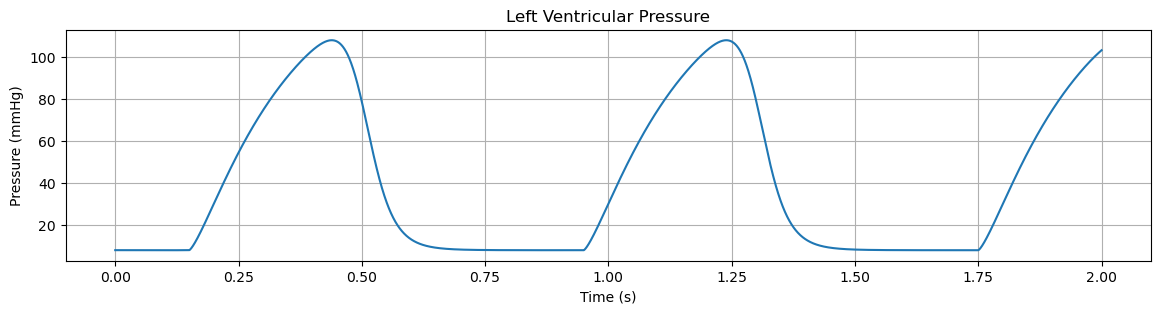

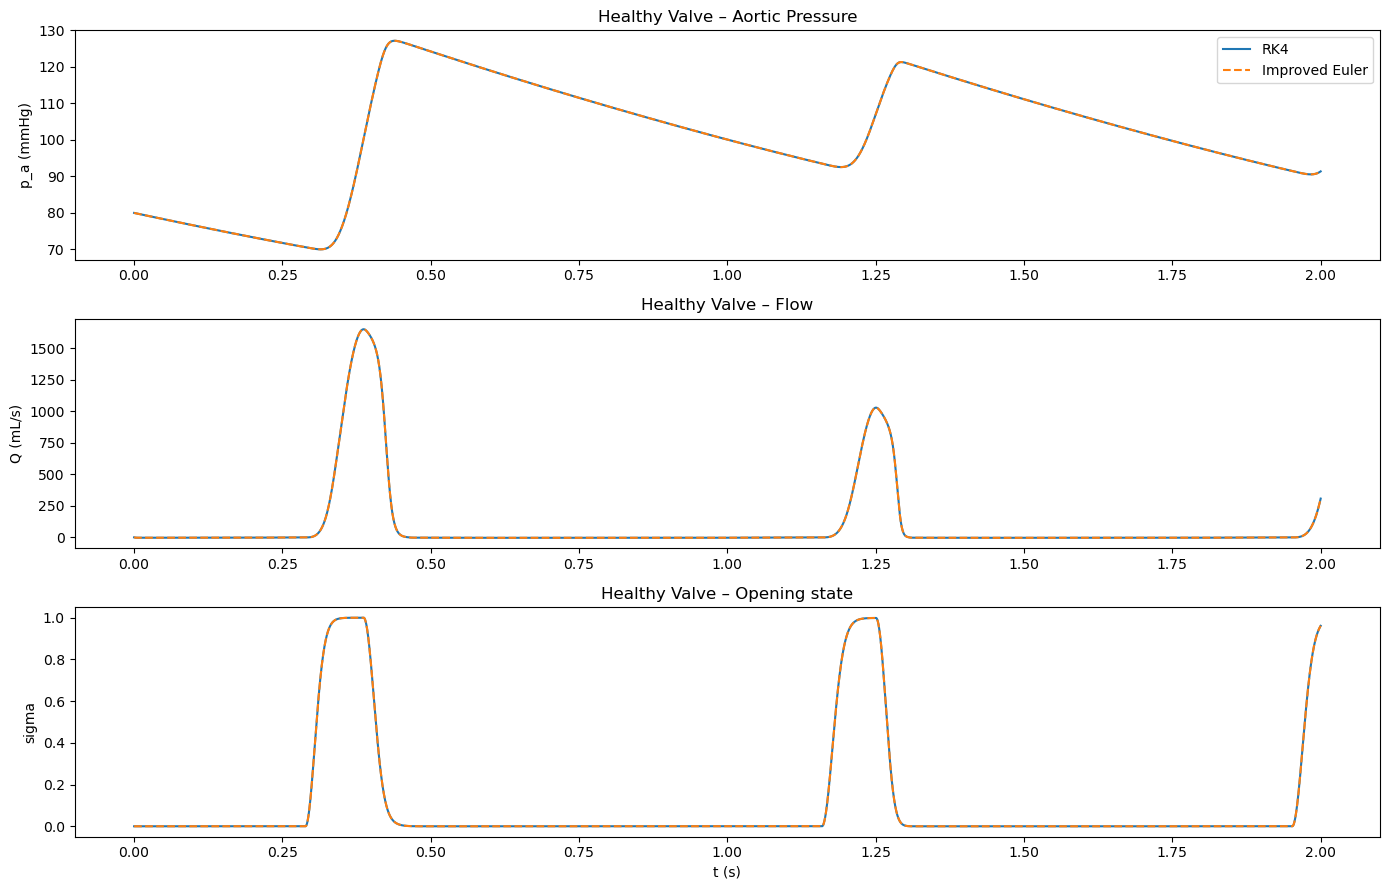

In [16]:
name = "Healthy"
(ts_rk, y_rk), (ts_hn, y_hn) = results[name]["rk4"], results[name]["heun"]

plt.figure(figsize=(14, 3))

ts = np.linspace(0, 2.0, 5000)
p_lv = p_LV_mmHg(ts)

# Left Ventricular pressure
plt.plot(ts, p_lv)
plt.title("Left Ventricular Pressure")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (mmHg)")
plt.grid()
plt.show()

plt.figure(figsize=(14, 9))
# Pressure
plt.subplot(3,1,1)
plt.plot(ts_rk, y_rk[:,2]*Pa_to_mmHg, label="RK4")
plt.plot(ts_hn, y_hn[:,2]*Pa_to_mmHg, '--', label="Improved Euler")
plt.ylabel("p_a (mmHg)")
plt.title("Healthy Valve – Aortic Pressure")
plt.legend()

# Flow
plt.subplot(3,1,2)
plt.plot(ts_rk, y_rk[:,0]*1e6, label="RK4")
plt.plot(ts_hn, y_hn[:,0]*1e6, '--', label="Improved Euler")
plt.ylabel("Q (mL/s)")
plt.title("Healthy Valve – Flow")

# Sigma
plt.subplot(3,1,3)
plt.plot(ts_rk, y_rk[:,1], label="RK4")
plt.plot(ts_hn, y_hn[:,1], '--', label="Improved Euler")
plt.ylabel("sigma")
plt.xlabel("t (s)")
plt.title("Healthy Valve – Opening state")

plt.tight_layout()
plt.show()


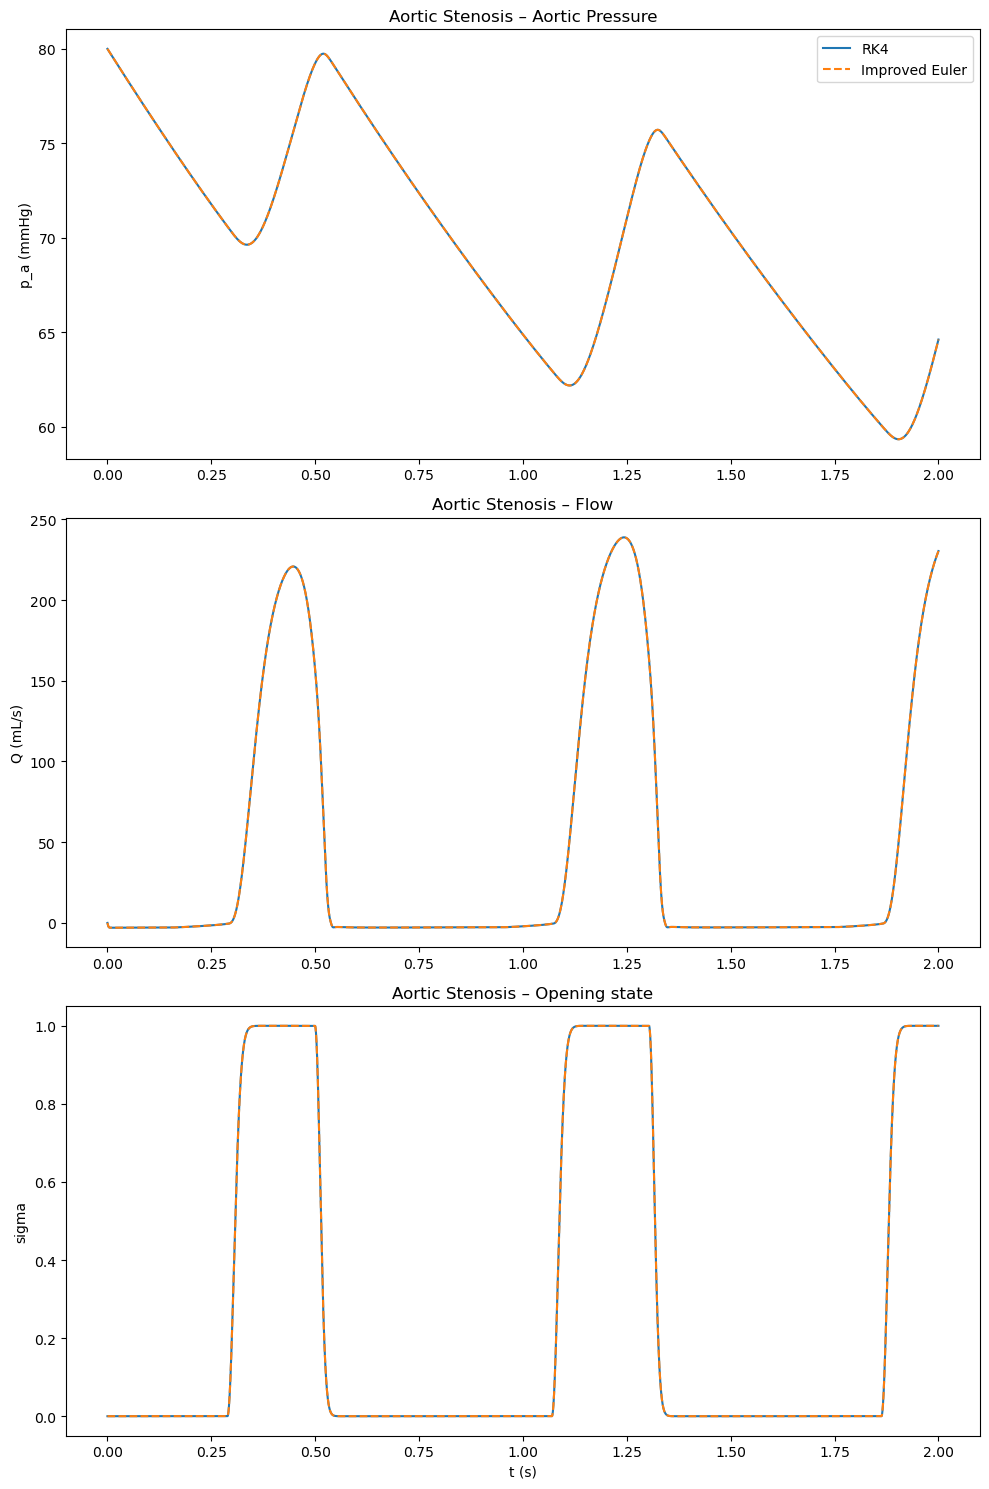

In [31]:
name = "Stenosis"
(ts_rk, y_rk), (ts_hn, y_hn) = results[name]["rk4"], results[name]["heun"]

plt.figure(figsize=(10, 15))

# Pressure
plt.subplot(3,1,1)
plt.plot(ts_rk, y_rk[:,2]*Pa_to_mmHg, label="RK4")
plt.plot(ts_hn, y_hn[:,2]*Pa_to_mmHg, '--', label="Improved Euler")
plt.ylabel("p_a (mmHg)")
plt.title("Aortic Stenosis – Aortic Pressure")
plt.legend()

# Flow
plt.subplot(3,1,2)
plt.plot(ts_rk, y_rk[:,0]*1e6, label="RK4")
plt.plot(ts_hn, y_hn[:,0]*1e6, '--', label="Improved Euler")
plt.ylabel("Q (mL/s)")
plt.title("Aortic Stenosis – Flow")

# Sigma
plt.subplot(3,1,3)
plt.plot(ts_rk, y_rk[:,1], label="RK4")
plt.plot(ts_hn, y_hn[:,1], '--', label="Improved Euler")
plt.ylabel("sigma")
plt.xlabel("t (s)")
plt.title("Aortic Stenosis – Opening state")

plt.tight_layout()
plt.show()


In [18]:
for name in ["Healthy", "Stenosis"]:
    ts, ys = results[name]["rk4"]
    p_lv = np.array([p_LV_mmHg(t) for t in ts])
    p_a = ys[:,2] * Pa_to_mmHg
    dp = p_lv - p_a
    print(f"{name}: Peak transvalvular gradient ≈ {dp.max():.1f} mmHg")


Healthy: Peak transvalvular gradient ≈ 15.4 mmHg
Stenosis: Peak transvalvular gradient ≈ 38.6 mmHg


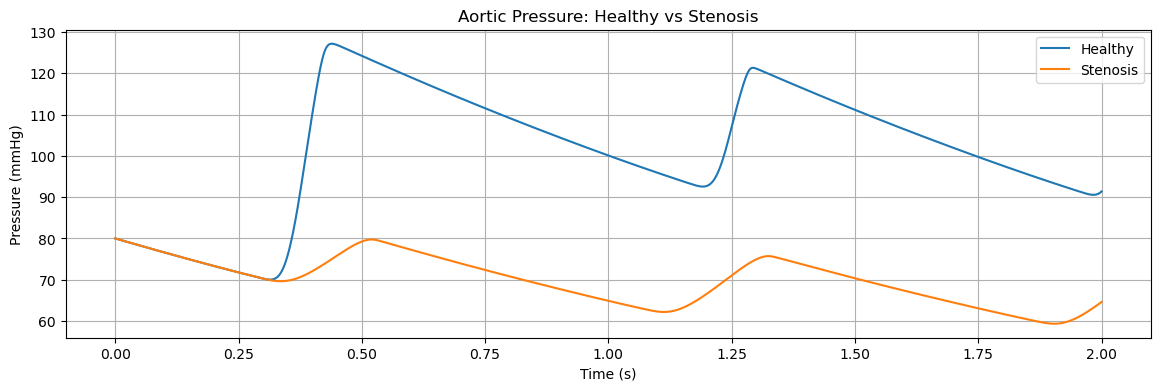

In [26]:
plt.figure(figsize=(14,4))

ts_h, ys_h = results["Healthy"]["rk4"]
ts_s, ys_s = results["Stenosis"]["rk4"]

plt.plot(ts_h, ys_h[:,2] * Pa_to_mmHg, label="Healthy")
plt.plot(ts_s, ys_s[:,2] * Pa_to_mmHg, label="Stenosis")

plt.title("Aortic Pressure: Healthy vs Stenosis")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (mmHg)")
plt.legend()
plt.grid()
plt.show()

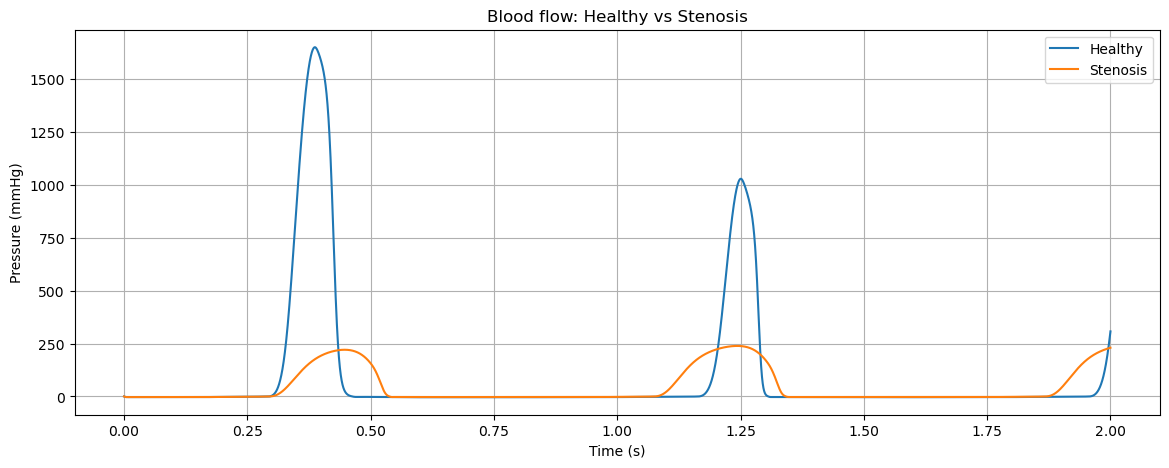

In [24]:
plt.figure(figsize=(14,5))

ts_h, ys_h = results["Healthy"]["rk4"]
ts_s, ys_s = results["Stenosis"]["rk4"]

plt.plot(ts_h, ys_h[:,0]*1e6, label="Healthy")
plt.plot(ts_s, ys_s[:,0]*1e6, label="Stenosis")

plt.title("Blood flow: Healthy vs Stenosis")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (mmHg)")
plt.legend()
plt.grid()
plt.show()

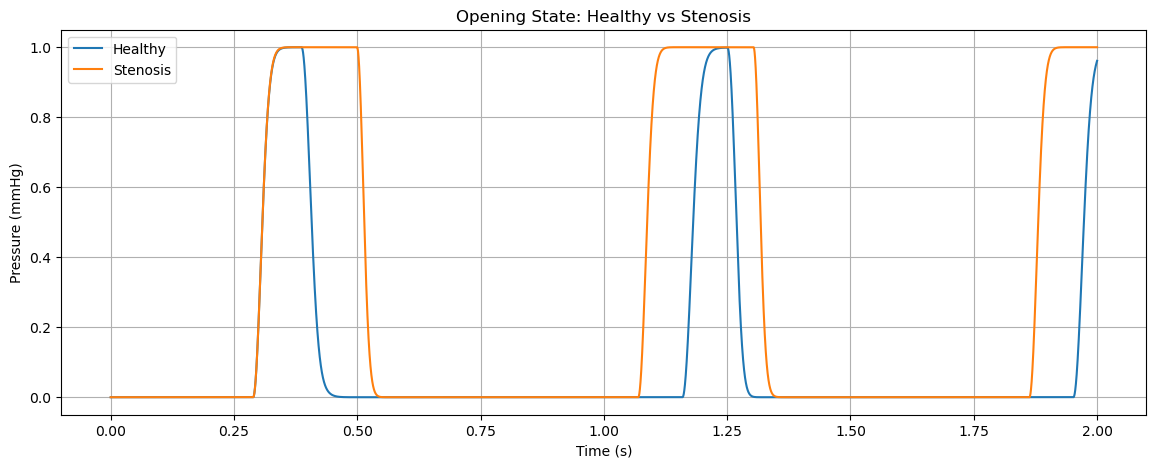

In [23]:
plt.figure(figsize=(14,5))

ts_h, ys_h = results["Healthy"]["rk4"]
ts_s, ys_s = results["Stenosis"]["rk4"]

plt.plot(ts_h, ys_h[:,1], label="Healthy")
plt.plot(ts_s, ys_s[:,1], label="Stenosis")

plt.title("Opening State: Healthy vs Stenosis")
plt.xlabel("Time (s)")
plt.ylabel("Pressure (mmHg)")
plt.legend()
plt.grid()
plt.show()